In [1]:
import os
import re
import shutil
import json
from tqdm import tqdm
import string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer
import pandas as pd
import numpy as np
import warnings
from argparse import Namespace
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
## Set seed 
seed = 121
np.random.seed(seed)
torch.random.manual_seed(seed)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
args = Namespace(
    train_file_path = '../input/bag-of-words-meets-bags-of-popcorn-/labeledTrainData.tsv',
    test_file_path = '../input/bag-of-words-meets-bags-of-popcorn-/testData.tsv',
    
    model_dir = 'models'
)

if os.path.exists(args.model_dir):
    shutil.rmtree(args.model_dir)
os.makedirs(args.model_dir, exist_ok=True)

In [5]:
## Load Data
train_df = pd.read_csv(args.train_file_path, delimiter='\t')
test_df = pd.read_csv(args.test_file_path, delimiter='\t')

In [6]:
## Split data into train and val data
X_train, X_val, y_train, y_val = train_test_split(train_df['review'].tolist(),
                                                  train_df['sentiment'].tolist(), 
                                                  test_size = 0.3,
                                                  random_state = 121)

In [7]:
len(X_train), len(y_train), len(X_val), len(y_val)

(17500, 17500, 7500, 7500)

In [8]:
tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
remove_words = string.punctuation + '0123456789'

In [9]:
def process_review(review):
    
    review = BeautifulSoup(review).get_text()    
    review = re.sub('^\w+','', review)
    review = re.sub('[.]','', review)
    tokens = tokenizer.tokenize(review)
    tokens = [w.lower() for w in tokens]
    clean_tokens = [w for w in tokens if w not in stop_words and w not in list(remove_words)]
    
    
    return clean_tokens

## Build Vocab
def build_vocab(reviews, threshold = 1, special_tokens = None):
    
    vocab = defaultdict(int)
    
    for review in reviews:
        for w in review:
            vocab[w] += 1
    
    
    vocab = [w for w,v in vocab.items() if v>threshold]
    
    if special_tokens:
        vocab = special_tokens + vocab
    
    vocab = {w:i for i,w in enumerate(vocab)}
    
    return vocab


def convert_review_to_feature(clean_review, vocab, unknown_token = '__UNK__'):
    
    feature = []
    
    for w in clean_review:
        if w in vocab:
            feature.append(vocab[w])
        else:
            feature.append(vocab[unknown_token])
            
    return feature


def add_padding(feature, max_len, pad_token_idx = 0):
    
    
    if len(feature)>max_len:
        feature = feature[:max_len]

    diff = max_len - len(feature)

    padding = [pad_token_idx] * diff

    feature += padding
    
    return feature

In [10]:
## Clean Data
clean_X_train = list(map(lambda x: process_review(x), X_train))
clean_X_val = list(map(lambda x: process_review(x), X_val))

In [11]:
## Build Vocab
special_tokens = ['__UNK__', '__PAD__']
vocab = build_vocab(clean_X_train, threshold=2,special_tokens = special_tokens)
len(vocab)

36689

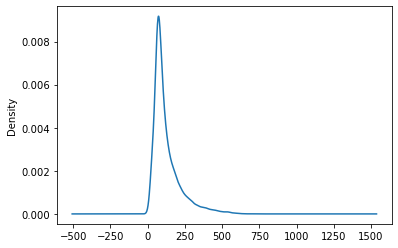

In [12]:
# Find max length of review
length_dist = pd.Series(list(map(lambda x: len(x), clean_X_train)))
length_dist.plot(kind = 'kde')

In [13]:
length_dist[length_dist <=400].shape[0]/length_dist.shape[0]

0.9746285714285714

In [14]:
max_len = 400

In [15]:
X_train_features = list(map(lambda x: convert_review_to_feature(x, vocab),clean_X_train))
X_val_features = list(map(lambda x: convert_review_to_feature(x, vocab),clean_X_val))

X_train_padded = list(map(lambda x: add_padding(x,max_len= max_len, pad_token_idx=vocab['__PAD__']),X_train_features))
X_val_padded = list(map(lambda x: add_padding(x,max_len= max_len, pad_token_idx=vocab['__PAD__']),X_val_features))

## Data Preparation

In [16]:
class SentimentDataset(Dataset):
    
    def __init__(self,reviews,labels):
        super(SentimentDataset, self)
        self.reviews = reviews
        self.labels = labels
        
    
    def __getitem__(self, index):
        return {'review': self.reviews[index], 'label': self.labels[index]}
    
    
    def __len__(self):
        return len(self.reviews)
    
    
    
class DataLoaderWrapper:
    
    def __init__(self, device, dataset, batch_size, shuffle, input_dim = 3):
        self.device = device
        self.dataset = dataset
        self.dataset_size = len(dataset)
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.input_dim = input_dim
        
    def __iter__(self):
        
        dataloader = DataLoader(self.dataset,batch_size = self.batch_size,shuffle = self.shuffle)
    
        for data in dataloader:
            review = torch.stack(data['review']).T
            label = data['label']
            if self.input_dim == 3:
                review = review.unsqueeze(dim = 2)
            yield review.to(device), label.to(device)
            
    def get_number_of_batches(self):
        return int(np.round(len(self.dataset)/self.batch_size,0))

## Modeling

In [17]:
def train_fn(model,dataloader,optimizer, loss_fn, data_type):
        
        
        ## training phase
        model.train()
        
        running_loss = 0
        correct = 0        
        number_of_batches = dataloader.get_number_of_batches()
        dataset_size = dataloader.dataset_size
        
       
        for review, label in dataloader:
            
            ## reset optimizer
            optimizer.zero_grad()
            
            if data_type == 'float':
                probs = model(review.float())
            elif data_type == 'long':
                probs = model(review.long())
            else:
                pribs = model(review)
                
            loss = loss_fn(probs, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pred_labels = torch.argmax(probs, dim = 1)
            correct += torch.sum(pred_labels == label).item()
        
        epoch_running_loss = running_loss/number_of_batches
        accuracy = correct/dataset_size
        
        return epoch_running_loss, accuracy

    
def eval_fn(model,dataloader,optimizer, loss_fn, data_type):
        
        ## validation phase
        model.eval()
        
        running_loss = 0
        correct = 0
        number_of_batches = dataloader.get_number_of_batches()
        dataset_size = dataloader.dataset_size
        
        for review, label in dataloader:
            if data_type == 'float':
                probs = model(review.float())
            elif data_type == 'long':
                probs = model(review.long())
            else:
                pribs = model(review)
                
            loss = loss_fn(probs, label)
            running_loss += loss.item()
            pred_labels = torch.argmax(probs, dim = 1)
            
            running_loss += loss.item()
            correct += torch.sum(pred_labels == label).item()
            
        
        epoch_running_loss = running_loss/number_of_batches
        accuracy = correct/dataset_size
        
        return epoch_running_loss, accuracy
    
    
def train(model,train_dataloader,val_dataloader, epochs, optimizer, loss_fn, verbose = True, data_type = 'float'):

    print("Training Starts  ")
    best_val_loss = 100000

    for epoch in range(epochs):

        ## Training
        train_loss, train_acc = train_fn(model,train_dataloader, optimizer, loss_fn, data_type)
        
        ## Validation
        val_loss, val_acc = eval_fn(model,val_dataloader, optimizer, loss_fn, data_type)

        if verbose: 
            loss_log = f" Train loss: {train_loss:.3f}  Val loss: {val_loss:.3f}"
            acc_log = f" Train accuracy : {train_acc:.3f}  Val accuarcy : {val_acc:.3f}"
            print(f"Epoch : {epoch} "+ loss_log + acc_log)


        if best_val_loss > val_loss:
            best_val_loss = val_loss
            model_path = f"models/epoch_{epoch}_best_val_loss_model.model"
            torch.save(model.state_dict(), model_path)

 ## Data For RNNs

In [18]:
epochs = 5
batch_size = 32
learning_rate = 0.00001

## Prepare data
train_dataset = SentimentDataset(X_train_padded, y_train)
val_dataset = SentimentDataset(X_val_padded, y_val)

train_dl = DataLoaderWrapper(device, train_dataset, batch_size, True, input_dim=3)
val_dl = DataLoaderWrapper(device, val_dataset, batch_size, False, input_dim=3)

# Simple RNN

In [19]:
# Input data must have dim : [batch_size, seq_len, input_size]
## RNN returns : out, hidden
# out : [batch, seq_len, num_directions * hidden_size]
# hidden : [num_layers * num_directions, batch, hidden_size]
# num_directions = 2 for bidirectional RNNs and 1 otherwise.


class SimpleRNN(nn.Module):
    
    def __init__(self, seq_len,input_size, output_dim):
        super(SimpleRNN, self).__init__()
        
        self.rnn1 = nn.RNN(input_size = input_size, hidden_size = 300, batch_first = True)
        self.rnn2 = nn.RNN(input_size= 300, hidden_size = 100, batch_first= True)
        
        self.dropout=nn.Dropout(0.2)
        
        self.flatten  = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 100 * seq_len, out_features= 256)
        self.linear2 = nn.Linear(in_features= 256, out_features= output_dim)
        
    
    def forward(self, review):
        
        out, hidden = self.rnn1(review)
        out, hidden = self.rnn2(out)
        
        output = self.flatten(out)
        
        output = self.linear1(output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = F.softmax(output,dim = 1)
        return output

In [20]:
## Prapare training
model = SimpleRNN(seq_len= max_len,input_size=1, output_dim=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## Training
model.to(device)
train(model,train_dl, val_dl,epochs, optimizer, loss_fn, data_type = 'float')

Training Starts  
Epoch : 0  Train loss: 0.700  Val loss: 1.389 Train accuracy : 0.520  Val accuarcy : 0.517
Epoch : 1  Train loss: 0.687  Val loss: 1.390 Train accuracy : 0.544  Val accuarcy : 0.526
Epoch : 2  Train loss: 0.681  Val loss: 1.397 Train accuracy : 0.560  Val accuarcy : 0.527
Epoch : 3  Train loss: 0.676  Val loss: 1.404 Train accuracy : 0.570  Val accuarcy : 0.530
Epoch : 4  Train loss: 0.671  Val loss: 1.388 Train accuracy : 0.576  Val accuarcy : 0.540


# LSTM RNN

In [21]:
class LSTMRNN(nn.Module):
    
    def __init__(self, seq_len,input_size, output_dim):
        super(LSTMRNN, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = 200, batch_first = True)
        self.lstm2 = nn.LSTM(input_size= 200, hidden_size = 50, batch_first= True)
        self.dropout=nn.Dropout(0.2)
        self.flatten  = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 50 * seq_len, out_features= 256)
        self.linear2 = nn.Linear(in_features= 256, out_features= output_dim)
        
    
    def forward(self, review):
        
        out, (h_n, c_n) = self.lstm1(review)
        out, (h_n, c_n) = self.lstm2(out)
        
        output = self.flatten(out)
        output = self.linear1(output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = F.softmax(output,dim = 1)
    
        return output

In [ ]:
## Prapare training
model = LSTMRNN(seq_len= max_len,input_size=1, output_dim=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## Training
model.to(device)
train(model,train_dl, val_dl,epochs, optimizer, loss_fn, data_type = 'float')

Training Starts  
Epoch : 0  Train loss: 0.693  Val loss: 1.387 Train accuracy : 0.513  Val accuarcy : 0.535
Epoch : 1  Train loss: 0.691  Val loss: 1.385 Train accuracy : 0.531  Val accuarcy : 0.528
Epoch : 2  Train loss: 0.687  Val loss: 1.378 Train accuracy : 0.545  Val accuarcy : 0.542
Epoch : 3  Train loss: 0.683  Val loss: 1.370 Train accuracy : 0.557  Val accuarcy : 0.557


# BiLSTM RNN

In [ ]:
class BiLSTMRNN(nn.Module):
    
    def __init__(self, seq_len,input_size, output_dim):
        super(BiLSTMRNN, self).__init__()
        
        self.bilstm1 = nn.LSTM(input_size = input_size, hidden_size = 100, batch_first = True, bidirectional = True)
        self.bilstm2 = nn.LSTM(input_size= 200, hidden_size = 50, batch_first= True, bidirectional = True)
        self.dropout = nn.Dropout(0.2)
        self.flatten  = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 100 * seq_len, out_features= 256)
        self.linear2 = nn.Linear(in_features= 256, out_features= output_dim)
        
    
    def forward(self, review):
        
        out, (h_n, c_n) = self.bilstm1(review)
        out, (h_n, c_n) = self.bilstm2(F.relu(out))
        
        output = self.flatten(F.relu(out))
        output = self.linear1(output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = F.softmax(output,dim = 1)
    
        return output

In [ ]:
## Prapare training
model = BiLSTMRNN(seq_len= max_len,input_size=1, output_dim=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## Training
model.to(device)
train(model,train_dl, val_dl,epochs, optimizer, loss_fn, data_type = 'float')

# BiLSTM with embedding layer

In [ ]:
class BiLSTMEmbedding(nn.Module):
    
    def __init__(self, seq_len,vocab_size, output_dim):
        super(BiLSTMEmbedding, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim = 300)
        self.bilstm1 = nn.LSTM(input_size = 300, hidden_size = 100, batch_first = True, bidirectional = True)
        self.bilstm2 = nn.LSTM(input_size= 200, hidden_size = 50, batch_first= True, bidirectional = True)
        
        self.flatten  = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 100 * seq_len, out_features= 256)
        self.linear2 = nn.Linear(in_features= 256, out_features= output_dim)
        
    
    def forward(self, review):
        
        embedding = self.embedding(review)
        out, (h_n, c_n) = self.bilstm1(embedding)
        out, (h_n, c_n) = self.bilstm2(F.relu(out))
        
        output = self.flatten(F.relu(out))
        output = self.linear1(output)
        output = F.softmax(self.linear2(output),dim = 1)
    
        return output

In [ ]:
train_dl = DataLoaderWrapper(device, train_dataset, batch_size, True, input_dim = 2)
val_dl = DataLoaderWrapper(device, val_dataset, batch_size, False, input_dim = 2)


## Prapare training
model = BiLSTMEmbedding(seq_len= max_len,vocab_size=len(vocab), output_dim=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## Training
model.to(device)
train(model,train_dl, val_dl,epochs, optimizer, loss_fn, data_type = 'long')

## BiLSTM with Glove embedding

In [ ]:
EMBEDDING_DIM = 50
GLOVE_FILE_PATH = '../input/glove6b50dtxt/glove.6B.50d.txt'

In [ ]:
glove = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f.readlines():
        k,v = line.split(' ',1)
        glove[k] = np.array(v.split(' '))

In [ ]:
matrix_len = len(vocab)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM, ))
        
weights_matrix = torch.Tensor(weights_matrix)

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [ ]:
class BiLSTMGloveEmbedding(nn.Module):
    
    def __init__(self, seq_len,vocab_size, output_dim):
        super(BiLSTMGloveEmbedding, self).__init__()
        
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.bilstm1 = nn.LSTM(input_size = embedding_dim, hidden_size = 100, batch_first = True, bidirectional = True)
        self.bilstm2 = nn.LSTM(input_size= 200, hidden_size = 50, batch_first= True, bidirectional = True)
        
        self.flatten  = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 100 * seq_len, out_features= 256)
        self.linear2 = nn.Linear(in_features= 256, out_features= output_dim)
        
    
    def forward(self, review):
        
        embedding = self.embedding(review)
        out, (h_n, c_n) = self.bilstm1(embedding)
        out, (h_n, c_n) = self.bilstm2(F.relu(out))
        
        output = self.flatten(F.relu(out))
        output = self.linear1(output)
        output = F.softmax(self.linear2(output),dim = 1)
    
        return output

In [ ]:
train_dl = DataLoaderWrapper(device, train_dataset, batch_size, True, input_dim = 2)
val_dl = DataLoaderWrapper(device, val_dataset, batch_size, False, input_dim = 2)


## Prapare training
model = BiLSTMGloveEmbedding(seq_len= max_len,vocab_size=len(vocab), output_dim=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## Training
model.to(device)
train(model,train_dl, val_dl,epochs, optimizer, loss_fn, data_type = 'long')